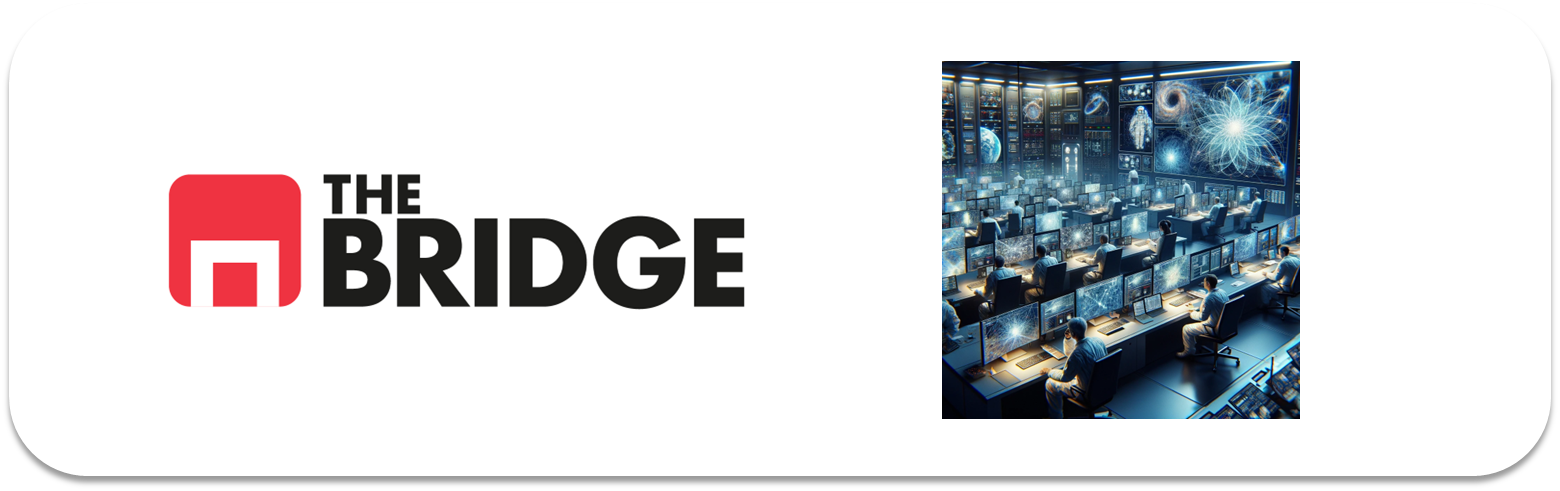

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [3]:
import tensorflow as tf

print("GPUs disponibles:", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs disponibles: 1


In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, VGG19, InceptionV3, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [ ]:
TRAIN_DIR = './seg_train/seg_train/'
TEST_DIR = './seg_test/seg_test/'
PRED_DIR = './seg_pred/seg_pred/'

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6

In [ ]:
# Preprocesamiento de los datos
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

# Cargar los datos con generadores

# Shuffle = True solo para train
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
pred_generator = pred_datagen.flow_from_directory(PRED_DIR, target_size=IMG_SIZE, batch_size=1, class_mode=None, shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 0 images belonging to 0 classes.


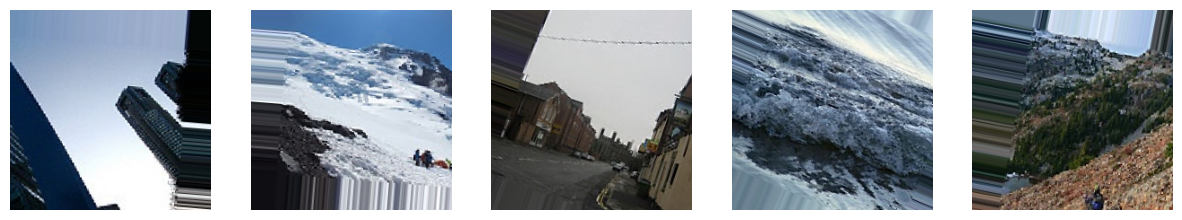

In [ ]:
def plot_images(generator):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for img, ax in zip(images[:5], axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

plot_images(train_generator)

### MobileNetV2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Transfer Learning: congelamos la base


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10
439/439 [==============================] - 241s 539ms/step - loss: 0.5564 - accuracy: 0.7949 - val_loss: 0.2962 - val_accuracy: 0.8883
Epoch 2/10
439/439 [==============================] - 101s 230ms/step - loss: 0.4206 - accuracy: 0.8458 - val_loss: 0.2891 - val_accuracy: 0.8857
Epoch 3/10
439/439 [==============================] - 102s 233ms/step - loss: 0.3893 - accuracy: 0.8564 - val_loss: 0.2550 - val_accuracy: 0.9007
Epoch 4/10
439/439 [==============================] - 101s 229ms/step - loss: 0.3671 - accuracy: 0.8650 - val_loss: 0.2689 - val_accuracy: 0.8930
Epoch 5/10
439/439 [==============================] - 101s 230ms/step - loss: 0.3664 - accuracy: 0.8653 - val_loss: 0.2519 - val_accuracy: 0.9083
Epoch 6/10
439/439 [==============================] - 102s 233ms/step - loss: 0.3514 - accuracy: 0.8695 - val_loss: 0.2598 - val_accuracy: 0.8990
Epoch 7/10
439/439 [==============================] - 101s 229ms/step - loss: 0.3468 - accuracy: 0.8747 - val_loss: 0.2603 -

### Evaluación contra test

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Pérdida en test: {loss:.4f}, Precisión en test: {accuracy:.4f}')

94/94 [==============================] - 4s 47ms/step - loss: 0.2451 - accuracy: 0.9037
Pérdida en test: 0.2451, Precisión en test: 0.9037


### Fine-tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Bloquear las primeras capas
    layer.trainable = False

# Tasa de aprendizaje menor
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_ft = model.fit(train_generator, validation_data=test_generator, epochs=10)


Epoch 1/10
439/439 [==============================] - 108s 241ms/step - loss: 0.5403 - accuracy: 0.8097 - val_loss: 0.2797 - val_accuracy: 0.9057
Epoch 2/10
439/439 [==============================] - 104s 237ms/step - loss: 0.3893 - accuracy: 0.8582 - val_loss: 0.2835 - val_accuracy: 0.9057
Epoch 3/10
439/439 [==============================] - 100s 229ms/step - loss: 0.3609 - accuracy: 0.8697 - val_loss: 0.2737 - val_accuracy: 0.9007
Epoch 4/10
439/439 [==============================] - 103s 234ms/step - loss: 0.3435 - accuracy: 0.8744 - val_loss: 0.2532 - val_accuracy: 0.9037
Epoch 5/10
439/439 [==============================] - 133s 302ms/step - loss: 0.3150 - accuracy: 0.8859 - val_loss: 0.2427 - val_accuracy: 0.9127
Epoch 6/10
439/439 [==============================] - 104s 236ms/step - loss: 0.3113 - accuracy: 0.8853 - val_loss: 0.2346 - val_accuracy: 0.9133
Epoch 7/10
439/439 [==============================] - 103s 234ms/step - loss: 0.2993 - accuracy: 0.8924 - val_loss: 0.2346 -

### Evaluación contra test

In [ ]:
loss_ft, accuracy_ft = model.evaluate(test_generator)
print(f'Fine-Tuned Pérdida en test: {loss_ft:.4f}, Precisión en test: {accuracy_ft:.4f}')

94/94 [==============================] - 4s 46ms/step - loss: 0.2259 - accuracy: 0.9107
Fine-Tuned Pérdida en test: 0.2259, Precisión en test: 0.9107


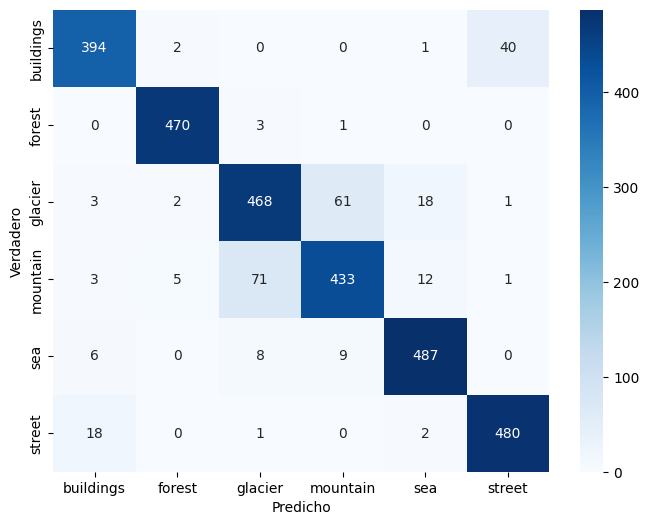

In [27]:
# Predicciones y matriz de confusión
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

In [28]:
# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

              precision    recall  f1-score   support

   buildings       0.93      0.90      0.92       437
      forest       0.98      0.99      0.99       474
     glacier       0.85      0.85      0.85       553
    mountain       0.86      0.82      0.84       525
         sea       0.94      0.95      0.95       510
      street       0.92      0.96      0.94       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

